<a href="https://colab.research.google.com/github/khadijaAssem/IMDb-reviews-classification/blob/main/Classical_Machine_Learning_for_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import csv
import os
import re

from tempfile import TemporaryFile

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA


from gensim.models.fasttext import FastText
from gensim.test.utils import common_texts  # some example sentences

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')

from wordcloud import WordCloud,STOPWORDS

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from scipy.sparse import csr_matrix

from google.colab import drive
from tqdm import tqdm

# !pip install fasttext

# import fasttext
# import fasttext.util


# ---- Call tqdm to see progress bar with pandas
# tqdm().pandas()

In [ ]:
!pip install fasttext

import fasttext
import fasttext.util

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/KH

/content/drive/MyDrive/KH


Navigating to the data files path

In [ ]:
ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
'Classical Machine Learning for NLP.ipynb'   Test.csv
 crawl-300d-2M-subword.bin                   test_cv.npy
 crawl-300d-2M-subword.vec                   test_embedding_matrix.npy
 fasttexttrained10_8.model                   Test_Labeled.csv
 imdbEr.txt                                  test_nopre_cv.npy
 imdb.vocab                                  test_nopre_tfid
 lemmanized_test.txt                         test_tfid.npy
 lemmanized_train.txt                        test_tokens.txt
 lemmatize_test_tokens.txt                   train@
 lemmatize_train_tokens.txt                  Train.csv
 np_lemmanized_test.npy                      train_cv.npy
 np_lemmanized_train.npy                     train_embedding_matrix.npy
 np_lemmatize_test_tokens.npy                Train_Labeled.csv
 np_lemmatize_train_tokens.npy               train_nopre_cv.npy
 np_test_tokens.npy             

In [ ]:
cd drive/MyDrive/College/Term 9/dataMining/

/content/drive/MyDrive/College/Term 9/dataMining


# To read data from files

In [ ]:
def get_train_tokens():
  return np.load('Lab3//np_train_tokens.npy')

def get_test_tokens():
  return np.load('Lab3//np_test_tokens.npy')

def get_lemmatize_train_tokens():
  return np.load('Lab3//np_lemmatize_train_tokens.npy', allow_pickle=True)

def get_lemmatize_test_tokens():
  return np.load('Lab3//np_lemmatize_test_tokens.npy', allow_pickle=True)

def get_lemmanized_train():
  return np.load('Lab3//np_lemmanized_train.npy')

def get_lemmanized_test():
  return np.load('Lab3//np_lemmanized_test.npy')

def get_original_data():
  return pd.read_csv('Lab3//Train.csv')['Comment'], pd.read_csv('Lab3//Test.csv')['Comment']

def get_cv ():
  return np.load('Lab3//train_cv.npy', allow_pickle=True), np.load('Lab3//test_cv.npy', allow_pickle=True)

def get_tfidf():
  return np.load('Lab3//train_tfid.npy', allow_pickle=True), np.load('Lab3//test_tfid.npy', allow_pickle=True)

def get_without_preprocessing_cv():
  return np.load('Lab3//train_nopre_cv.npy', allow_pickle=True), np.load('Lab3//test_nopre_cv.npy', allow_pickle=True) 

def get_without_preprocessing_tfid():
  return np.load('Lab3//train_nopre_tfid.npy', allow_pickle=True), np.load('Lab3//test_nopre_tfid.npy', allow_pickle=True) 

def get_embedding_train():
  return np.load('train_embedding_matrix.npy', allow_pickle=True) 

def get_embedding_test():
  return np.load('test_embedding_matrix.npy', allow_pickle=True) 

# Creating CSV files

Global Vars

In [ ]:
SEPARATOR = '_'
NEGATIVE_LABEL = 'NEGATIVE'
POSITIVE_LABEL = 'POSITIVE'

Reading file names for all data files 

In [ ]:
dataFilesPaths = ['/train/pos/', '/train/neg/', '/test/pos/', '/test/neg/']

mypath = os.getcwd()
filenames = {'/train/pos/': [], '/train/neg/': [], '/test/pos/': [], '/test/neg/': []}
for filePath in dataFilesPaths:
  filenames[filePath] = next(os.walk(mypath+filePath), (None, None, []))[2]  # [] if no file

Train positive : 12500

Train negative : 12500

Test positive : 12500

Test negative : 12500

In [ ]:
def getDataTuples(foldersPaths):
  dataTuples = []
  for filePath in foldersPaths:
    print(filePath)
    count = 0
    for filename in filenames[filePath]:
      count += 1
      file = open(mypath+filePath+filename, "r")
      rate = int(filename[int(filename.index(SEPARATOR)+1)])
      if (filename[int(filename.index(SEPARATOR)+2)] == '0'): rate = 10
      dataTuples.append((file.read(), rate))
      file.close()
      print(count)
    print(count)
  return dataTuples

In [ ]:
''' A negative review has a score <= 4 out of 10,
and a positive review has a score >= 7 out of 10. Thus reviews with
more neutral ratings are not included in the train/test sets. In the
unsupervised set, reviews of any rating are included and there are an
even number of reviews > 5 and <= 5.
'''

def getLabeledDataTuples(foldersPaths):
  dataTuples = []
  for filePath in foldersPaths:
    print(filePath)
    count = 0
    for filename in filenames[filePath]:
      count += 1
      file = open(mypath+filePath+filename, "r")
      rate = int(filename[int(filename.index(SEPARATOR)+1)])
      if (filename[int(filename.index(SEPARATOR)+2)] == '0'): rate = 10
      label = POSITIVE_LABEL
      if(rate <= 4): label = NEGATIVE_LABEL
      dataTuples.append((file.read(), label))
      file.close()
      print(count)
    print(count)
  return dataTuples

In [ ]:
def generateUnlabeledTrainFile():
  print(dataFilesPaths[:2])
  trainDataTuples = getDataTuples(dataFilesPaths[:2])
  traindf = pd.DataFrame(trainDataTuples, columns = ['Comment', 'Rate'])
  print(traindf)
  train_compression_opts = dict(method='zip', archive_name='Train.csv')  
  traindf.to_csv('Train.zip', index=False, compression=train_compression_opts)

In [ ]:
def generateUnlabeledTestFile():
  print(dataFilesPaths[2:])
  testDataTuples = getDataTuples(dataFilesPaths[2:])
  testdf = pd.DataFrame(testDataTuples, columns = ['Comment', 'Rate'])
  print(testdf)
  test_compression_opts = dict(method='zip', archive_name='Test.csv')  
  testdf.to_csv('Test.zip', index=False, compression=test_compression_opts)

In [ ]:
def generateLabeledTrainFile():
  print(dataFilesPaths[:2])
  trainDataTuples = getLabeledDataTuples(dataFilesPaths[:2])
  traindf = pd.DataFrame(trainDataTuples, columns = ['Comment', 'Label'])
  print(traindf)
  train_compression_opts = dict(method='zip', archive_name='Train_Labeled.csv')  
  traindf.to_csv('Train_Labeled.zip', index=False, compression=train_compression_opts)

In [ ]:
def generateLabeledTestFile():
  print(dataFilesPaths[2:])
  testDataTuples = getLabeledDataTuples(dataFilesPaths[2:])
  testdf = pd.DataFrame(testDataTuples, columns = ['Comment', 'Rate'])
  print(testdf)
  test_compression_opts = dict(method='zip', archive_name='Test_Labeled.csv')  
  testdf.to_csv('Test_Labeled.zip', index=False, compression=test_compression_opts)

In [ ]:
generateLabeledTrainFile()
generateLabeledTestFile()

# Preprocessing

cleaning

removing punctuation and html words like

In [ ]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

# test_data['Comment']=preprocess_reviews(test_data['Comment'])
# train_data['Comment']=preprocess_reviews(train_data['Comment'])

# print(train_data)
# print(test_data)



 **stop words removal**
 
 like ('i', 'me', 'my', 'myself', 'we')

In [ ]:

#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')


def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
# #Apply function on review column
# train_data['Comment']=train_data['Comment'].apply(remove_stopwords)
# test_data['Comment']=test_data['Comment'].apply(remove_stopwords)

# print(train_data)
# print(test_data)


**Tokenization**

In [ ]:
def tokenize(text):
    ret_tokens=[]
    for item in text:
      tokens = tokenizer.tokenize(item)
      ret_tokens.append(tokens)
    return(ret_tokens)
    
# train_tokens=tokenize(train_data['Comment'])
# test_tokens=tokenize(test_data['Comment'])

In [ ]:
# print(train_tokens[0])
# print(train_data['Comment'])

**lemmatization** 

*(links words with similar meanings to one word)*

(rocks ==> rock, corpora ==> corpus, better ==> good )


In [ ]:

def lemmatize(tokens):
  lemmatize_tokens = []
  lemmatizer = WordNetLemmatizer()
  for item in tokens:
      words = [lemmatizer.lemmatize(word) for word in item]
      lemmatize_tokens.append(words)
  return lemmatize_tokens 

# lemmatize_train_tokens=lemmatize(train_tokens)
# lemmatize_test_tokens=lemmatize(test_tokens)


In [ ]:
#return array of strings to 
def listToString(data): 
  arr=[]
  for item in data:
    str1 = " " 
    str= str1.join(item) 
    arr.append(str) 
  return(arr) 


**Applying preprocessing**

In [ ]:
def save_to_file(fname, data):
  with open(fname, "w") as txt_file:
      for line in data:
          txt_file.write(" ".join(line) + "\n") # works with any number of elements in a line

In [ ]:
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')

test_data['Comment']=preprocess_reviews(test_data['Comment'])
train_data['Comment']=preprocess_reviews(train_data['Comment'])

#Apply function on review column
train_data['Comment']=train_data['Comment'].apply(remove_stopwords)
test_data['Comment']=test_data['Comment'].apply(remove_stopwords)

train_tokens=tokenize(train_data['Comment'])
test_tokens=tokenize(test_data['Comment'])

np_train_tokens = np.matrix(train_tokens)
with open('np_train_tokens.npy', 'wb') as f:
    np.save(f, np_train_tokens )

np_test_tokens = np.matrix(test_tokens)
with open('np_test_tokens.npy', 'wb') as f:
    np.save(f, np_test_tokens )

# save_to_file('train_tokens.txt', train_tokens)
# save_to_file('test_tokens.txt', test_tokens)

lemmatize_train_tokens=lemmatize(train_tokens)
lemmatize_test_tokens=lemmatize(test_tokens)

np_lemmatize_train_tokens = np.matrix(lemmatize_train_tokens)
with open('np_lemmatize_train_tokens.npy', 'wb') as f:
    np.save(f, np_lemmatize_train_tokens)

np_lemmatize_test_tokens = np.matrix(lemmatize_test_tokens)
with open('np_lemmatize_test_tokens.npy', 'wb') as f:
    np.save(f, np_lemmatize_test_tokens)

# save_to_file('lemmatize_train_tokens.txt', lemmatize_train_tokens)
# save_to_file('lemmatize_test_tokens.txt', lemmatize_test_tokens)

lemmanized_train=listToString(lemmatize_train_tokens)
lemmanized_test=listToString(lemmatize_test_tokens)

np_lemmanized_train = np.matrix(lemmanized_train)
with open('np_lemmanized_train.npy', 'wb') as f:
    np.save(f, np_lemmanized_train)

np_lemmanized_test = np.matrix(lemmanized_test)
with open('np_lemmanized_test.npy', 'wb') as f:
    np.save(f, np_lemmanized_test)

# save_to_file('lemmanized_train.txt', lemmanized_train)
# save_to_file('lemmanized_test.txt', lemmanized_test)

# del lemmatize_train_tokens
# del lemmatize_test_tokens

/usr/local/lib/python3.7/dist-packages/numpy/matrixlib/defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr = N.array(data, dtype=dtype, copy=copy)


In [ ]:
del(train_data)
del(test_data)
del(train_tokens)
del(test_tokens)
del(REPLACE_NO_SPACE)
del(REPLACE_WITH_SPACE)
del(preprocess_reviews)
del(tokenizer)
del(stopword_list)
del(remove_stopwords)
del(tokenize)
del(lemmatize)
del(listToString)
del(np_train_tokens)
del(np_test_tokens)
del(np_lemmatize_train_tokens)
del(np_lemmatize_test_tokens)
del(np_lemmanized_train)
del(np_lemmanized_test)
del(lemmatize_train_tokens)
del(lemmatize_test_tokens)

#  Corpus Analysis 

In [ ]:
maximum_train_sentence_ltngth = 0 # = 9223
for sent in lemmanized_train:
  maximum_train_sentence_ltngth = max(maximum_train_sentence_ltngth, len(sent))
print(maximum_train_sentence_ltngth)

maximum_test_sentence_ltngth = 0 # = 8449
for sent in lemmanized_test:
  maximum_test_sentence_ltngth = max(maximum_test_sentence_ltngth, len(sent))
print(maximum_test_sentence_ltngth)


def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item


distinct_train_words = list(uniq(sorted(lemmatize_train_tokens, reverse=True)))
distinct_test_words = list(uniq(sorted(lemmatize_test_tokens, reverse=True)))
sum_lemmatized = list(lemmatize_train_tokens)
sum_lemmatized.extend(lemmatize_test_tokens)
distinct_all_words = list(uniq(sorted(sum_lemmatized, reverse=True)))

print(len(distinct_train_words)) # 24901
print(len(distinct_test_words)) # 24797
print(len(distinct_all_words)) # 49575

#Creating data matrix

Converting the text of each review (after pre-processing) into a vector form to construct the data
matrix

**Traditional methods (BOW, TF-IDF, etc.)**

Using N-grams (1, 3) 

why? since https://stackabuse.com/python-for-nlp-developing-an-automatic-text-filler-using-n-grams/


In [ ]:
#  Using sklearn feature vectorizer (Count) to create the required feature vector
#  Useful Link: https://stackabuse.com/python-for-nlp-creating-bag-of-words-model-from-scratch/

def countVector(traindata, testdata):
  CountVec = CountVectorizer(binary=True,ngram_range=(1,3))
  ''' stop_words: If None(default), no stop words will be used. max_df can be set to a value in the range [0.7, 1.0) 
  to automatically detect and filter stop words based on intra corpus document frequency of terms. 
  max_df = 1 by default '''

  train_BOWCV = CountVec.fit_transform(traindata) # This is equivalent to fit followed by transform, but more efficiently implemented.
  test_BOWCV = CountVec.transform(testdata)

  print('train_BOWCV:',train_BOWCV.shape)
  print('test_BOWCV:',test_BOWCV.shape)

  return train_BOWCV ,test_BOWCV

In [ ]:
#  Using sklearn feature vectorizer (TF-IDF) to create the required feature vector
#  Using Link: https://stackabuse.com/python-for-nlp-creating-tf-idf-model-from-scratch/

def TfidVector(traindata, testdata):
  TfidfVec = TfidfVectorizer(binary=True,ngram_range=(1,3))

  train_BOWTFID = TfidfVec.fit_transform(traindata)
  test_BOWTFID = TfidfVec.transform(testdata)

  print('train_BOWTFID:',train_BOWTFID.shape)
  print('test_BOWTFID:',test_BOWTFID.shape)

  return train_BOWTFID, test_BOWTFID

**Word Embedding**

https://stackabuse.com/python-for-nlp-word-embeddings-for-deep-learning-in-keras/

Here embedding_size is the size of the embedding vector. In other words, each word in our corpus will be represented as a 60-dimensional vector. The window_size is the size of the number of words occurring before and after the word based on which the word representations will be learned for the word. This might sound tricky, however in the skip-gram model we input a word to the algorithm and the output is the context words. If the window size is 40, for each input there will be 80 outputs: 40 words that occur before the input word and 40 words that occur after the input word. The word embeddings for the input word are learned using these 80 output words.

The next hyper-parameter is the min_word, which specifies the minimum frequency of a word in the corpus for which the word representations will be generated. Finally, the most frequently occurring word will be down-sampled by a number specified by the down_sampling attribute.

In [ ]:
'''fastText can obtain vectors even for out-of-vocabulary (OOV) words, 
by summing up vectors for its component char-ngrams, 
provided at least one of the char-ngrams was present in the training data.
'''

# download pretrained model zipped and unzip it

# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
# !unzip crawl-300d-2M-subword.zip

MAX_LEN = 100

pretrained = fasttext.FastText.load_model('Lab3//crawl-300d-2M-subword.bin')

def WordEmbedding(lemmatized_data):
  # create token-embedding mapping
  token = Tokenizer()
  token.fit_on_texts(lemmatized_data)
  word_index = token.word_index
  # convert text to sequence of tokens and pad them to ensure equal length vectors 
  train_seq_x = sequence.pad_sequences(token.texts_to_sequences(lemmatized_data), maxlen=300)

  embedding_matrix = np.zeros((MAX_LEN, 300))
  words = []
  for word, i in word_index.items():
      if i >= MAX_LEN:
            continue
      embedding_vector = pretrained[word] #embeddings_index.get(word)
      words.append(word)
      if embedding_vector is not None: # if word in model
          embedding_matrix[i] = embedding_vector
  return list(np.concatenate(embedding_matrix).flat)#, pretrained
    


**Applying data matrix**

# Saving data matricies

**For data without no preprocessing count vectorizer**

In [ ]:
def save_nopreprocessd_cv():
  td , testd = get_original_data()
  train_nopre_cv, test_nopre_cv = countVector(td , testd)

  with open('Lab3//train_nopre_cv.npy', 'wb') as f:
      np.save(f, train_nopre_cv)

  with open('Lab3//test_nopre_cv.npy', 'wb') as f:
      np.save(f, test_nopre_cv)

save_nopreprocessd_cv()
del save_nopreprocessd_cv

train_BOWCV: (25000, 5165791)
test_BOWCV: (25000, 5165791)


**For data without no preprocessing tfidf**

In [ ]:
def save_nopreprocessd_tfidf():
  td , testd = get_original_data()
  train_tfid, test_tfid = TfidVector(td, testd)

  with open('Lab3//train_nopre_tfid.npy', 'wb') as f:
      np.save(f, train_tfid )

  with open('Lab3//test_nopre_tfid.npy', 'wb') as f:
      np.save(f, test_tfid)

save_nopreprocessd_tfidf()
del save_nopreprocessd_tfidf

train_BOWTFID: (25000, 5165791)
test_BOWTFID: (25000, 5165791)


**For data with count vector form**

In [ ]:
def save_cv():
  lemmanized_train = get_lemmanized_test().reshape(-1,).tolist()
  lemmanized_test = get_lemmanized_train().reshape(-1,).tolist()

  train_cv, test_cv = countVector(lemmanized_train, lemmanized_test)

  with open('Lab3//train_cv.npy', 'wb') as f:
      np.save(f, train_cv )

  with open('Lab3//test_cv.npy', 'wb') as f:
      np.save(f, test_cv)

save_cv()
del save_cv

train_BOWCV: (25000, 4515058)
test_BOWCV: (25000, 4515058)


**For data with TFIDF form**

In [ ]:
def save_tfidf():
  lemmanized_train = get_lemmanized_test().reshape(-1,).tolist()
  lemmanized_test = get_lemmanized_train().reshape(-1,).tolist()

  train_tfid, test_tfid = TfidVector(lemmanized_train, lemmanized_test)

  with open('Lab3//train_tfid.npy', 'wb') as f:
      np.save(f, train_tfid)

  with open('Lab3//test_tfid.npy', 'wb') as f:
      np.save(f, test_tfid)

save_tfidf()
del save_tfidf

train_BOWTFID: (25000, 4515058)
test_BOWTFID: (25000, 4515058)


**For data with embedding matrix form**

In [ ]:
sz = 25000

train_embedding_matrix = np.zeros((sz, MAX_LEN * 300))

lemmatize_train_tokens = get_lemmatize_train_tokens().reshape(-1,).tolist()

for i in range (0, sz):
  train_embedding_submatrix = WordEmbedding(lemmatize_train_tokens[0][i])
  train_embedding_matrix[i] = train_embedding_submatrix

del lemmatize_train_tokens
del train_embedding_submatrix
del pretrained

with open('train_embedding_matrix.npy', 'wb') as f:
    np.save(f, train_embedding_matrix)
  
del train_embedding_matrix


pretrained = fasttext.FastText.load_model('Lab3//crawl-300d-2M-subword.bin')


test_embedding_matrix = np.zeros((sz, MAX_LEN * 300))

lemmatize_test_tokens = get_lemmatize_test_tokens().reshape(-1,).tolist()

for i in range (0, sz):
  test_embedding_submatrix = WordEmbedding(lemmatize_test_tokens[0][i])
  test_embedding_matrix[i] = test_embedding_submatrix

del lemmatize_test_tokens
del test_embedding_submatrix
del pretrained

with open('test_embedding_matrix.npy', 'wb') as f:
    np.save(f, test_embedding_matrix)

del test_embedding_matrix

# Classification

# Logistic Regression

**Without preprocessing**

---
**For CV**


> 1. Accuracy for C=0.01: 0.8308
> 2. Accuracy for C=0.05: 0.8512
> 3. Accuracy for C=0.25: 0.8708
> 4. Accuracy for C=0.5: 0.8776
> 5. Accuracy for C=1: 0.8808

                              Accuracy of LR on test data C=1: 0.88864

**For TFIDF**


> 1. Accuracy for C=0.01: 0.8456
> 2. Accuracy for C=0.05: 0.8588
> 3. Accuracy for C=0.25: 0.8724
> 4. Accuracy for C=0.5: 0.8788
> 5. Accuracy for C=1: 0.8904

                            Accuracy of LR on test data C=1: 0.88988


**With Preprocessing**

---

**For CV**

> 1.   Accuracy for C=0.01: 0.8764
> 2.   Accuracy for C=0.05: 0.8796
> 3.   Accuracy for C=0.25: 0.8824
> 4.   Accuracy for C=0.5: 0.8824
> 5.   Accuracy for C=1: 0.8832

                                Accuracy of LR on test data C=1: 0.88448

**For TFIDF**

> 1.  Accuracy for C=0.01: 0.8396
> 2.  Accuracy for C=0.05: 0.8504
> 3.  Accuracy for C=0.25: 0.8552
> 4.  Accuracy for C=0.5: 0.8636
> 5.  Accuracy for C=1: 0.8724

                              Accuracy of LR on test data C=1: 0.875

**For embedding with maximum length = 10**

> 1.  Accuracy for C=0.01: 0.656
> 2.  Accuracy for C=0.05: 0.6828
> 3.  Accuracy for C=0.25: 0.696
> 4.  Accuracy for C=1: 0.6904

                              Accuracy of LR on test data C=0.5: 0.69536

**For embedding with maximum length = 50**


> 1. Accuracy for C=0.01: 0.7584
> 2. Accuracy for C=0.05: 0.7824
> 3. Accuracy for C=0.25: 0.7916
> 4. Accuracy for C=0.5: 0.7868
> 5. Accuracy for C=1: 0.776

                          Accuracy of LR on test data C=0.25: 0.7726709068362735


**For embedding with maximum length = 70**


> 1. Accuracy for C=0.01: 0.7496
> 2. Accuracy for C=0.05: 0.7824
> 3. Accuracy for C=0.25: 0.806
> 4. Accuracy for C=0.5: 0.7908
> 5. Accuracy for C=1: 0.7952

                          Accuracy of LR on test data C=0.25: 0.78484

**For embedding with maximum length = 100**

>1. For embedding
2. Accuracy for C=0.01: 0.7492
3. Accuracy for C=0.05: 0.7876
4. Accuracy for C=0.25: 0.798
5. Accuracy for C=0.5: 0.7944

                        Accuracy of LR on test data C=0.25: 0.7914

In [ ]:
def testLR(x_train, x_test, y_train, y_test, c):
  lr = LogisticRegression(C=c)
  lr.fit(x_train, y_train)
  accuracy = accuracy_score(y_test, lr.predict(x_test))
  return accuracy

def logstReg(trainBOW, trainTarget, testBOW, testTarget, embedding=False):
  if (embedding):
      x_train, x_val, y_train, y_val = train_test_split(trainBOW, trainTarget, train_size = 0.9) # Split data to validation and training  
  else:
      x_train, x_val, y_train, y_val = train_test_split(trainBOW.reshape(-1,).tolist()[0], trainTarget, train_size = 0.9) # Split data to validation and training
  bestAcc = 0; bestC = 0 # variables for keeping best c and best accuracy
  for c in [0.01, 0.05, 0.25, 0.5, 1]:  # Iterating on different c's for hyperparameter tunning
    acc = testLR(x_train, x_val, y_train, y_val, c) # Doing training and testing
    if (acc > bestAcc):
      bestC = c
      bestAcc = acc
    print ("Accuracy for C=%s: %s" % (c, acc))
  del x_train; del x_val; del y_train; del  y_val
  if (embedding):
    accuracy = testLR(trainBOW, testBOW, trainTarget, testTarget, bestC)
  else:
    train = csr_matrix(trainBOW.all())
    test = csr_matrix(testBOW.all())
    accuracy = testLR(train, test, trainTarget, testTarget, bestC)
  print("Accuracy of LR on test data C=%s: %s" % (bestC,accuracy))
  del trainBOW; del trainTarget; del testBOW; del  testTarget
  return accuracy


In [ ]:
target = [1 if i < 12500 else 0 for i in range(25000)]

def cvLR():
  print('For CV')
  train, test = get_cv()
  logstReg(train, target, test, target)

def tfidLR():
  print('For TFIDF')
  train, test = get_tfidf()
  logstReg(train, target, test, target)

def noprocess_cvLR():
  print('For no processing with cv')
  train, test = get_without_preprocessing_cv()
  logstReg(train, target, test, target)

def noprocess_TFIDFLR():
  print('For no processing with TFIDF')
  train, test = get_without_preprocessing_tfid()
  logstReg(train, target, test, target)

def embeddingLR():
  print('For embedding')
  train = get_embedding_train()
  test = get_embedding_test()
  logstReg(train, target, test, target, True)

cvLR()
del cvLR

tfidLR()
del tfidLR

noprocess_cvLR()
del noprocess_cvLR

noprocess_TFIDFLR()
del noprocess_TFIDFLR

embeddingLR()
del embeddingLR

del target

For embedding
Accuracy for C=0.01: 0.7492
Accuracy for C=0.05: 0.7876
Accuracy for C=0.25: 0.798


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy for C=0.5: 0.7944


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy for C=1: 0.7868


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy of LR on test data C=0.25: 0.7914


# Linear SVM

**Without preprocessing**

---
**Count Vector**

>1. Accuracy for C=0.0005: 0.892
2. Accuracy for C=0.0004: 0.8864
3. Accuracy for C=0.0003: 0.892
4. Accuracy for C=0.0002: 0.8908
5. Accuracy for C=0.0001: 0.886

                          Accuracy of SVM on test data C=0.0005: 0.89508

**For TFIDF**

>1. Accuracy for C=0.0005: 0.834
2. Accuracy for C=0.0004: 0.828
3. Accuracy for C=0.0003: 0.8528
4. Accuracy for C=0.0002: 0.8776
5. Accuracy for C=0.0001: 0.8924

                        Accuracy of SVM on test data C=0.0001: 0.88104

---

**With preprocessing**

---

**Count Vector**


>1. Accuracy for C=0.0005: 0.9024
2. Accuracy for C=0.0004: 0.9124
3. Accuracy for C=0.0003: 0.9096
4. Accuracy for C=0.0002: 0.9064
5. Accuracy for C=0.0001: 0.9048

                          Accuracy of SVM on test data C=0.0004: 0.88204

**For TFIDF**

>1. Accuracy for C=0.0005: 0.834
2. Accuracy for C=0.0004: 0.828
3. Accuracy for C=0.0003: 0.8528
4. Accuracy for C=0.0002: 0.8776
5. Accuracy for C=0.0001: 0.8924

                          Accuracy of SVM on test data C=0.0001: 0.88104

**For embedding**


>1. Accuracy for C=0.0001: 0.7012
2. Accuracy for C=5e-05: 0.7008
3. Accuracy for C=0.025: 0.554
4. Accuracy for C=0.5: 0.5132
5. Accuracy for C=1: 0.5132

                        Accuracy of SVM on test data C=0.0001: 0.69304


**For embedding max len = 50**

>1. Accuracy for C=0.0005: 0.76
2. Accuracy for C=0.0004: 0.7592
3. Accuracy for C=0.0003: 0.7532
4. Accuracy for C=0.0002: 0.744
5. Accuracy for C=0.0001: 0.744

                    Accuracy of SVM on test data C=0.0005: 0.7687107484299373

**For embedding max len = 70**

>1. Accuracy for C=0.0005: 0.7876
2. Accuracy for C=0.0004: 0.7872
3. Accuracy for C=0.0003: 0.7788
4. Accuracy for C=0.0002: 0.7744
5. Accuracy for C=0.0001: 0.7576

                    Accuracy of SVM on test data C=0.0005: 0.78204



In [ ]:
def testSVM(x_train, x_test, y_train, y_test, c):
  model = SGDClassifier(random_state=42,alpha=c)
  model.fit(x_train, y_train)
  accuracy = accuracy_score(y_test, model.predict(x_test))
  return accuracy

def svm_tuning(trainBOW, trainTarget, testBOW, testTarget, embedding=False):
    if (embedding):
      x_train, x_val, y_train, y_val = train_test_split(trainBOW, trainTarget, train_size = 0.9) # Split data to validation and training  
    else:
      x_train, x_val, y_train, y_val = train_test_split(trainBOW.reshape(-1,).tolist()[0], trainTarget, train_size = 0.9) # Split data to validation and training

    bestAcc = 0; bestC = 0 # variables for keeping best c and best accuracy
    for c in [0.0005, 0.0004, 0.0003, 0.0002, 0.0001]:  # Iterating on different c's for hyperparameter tunning
      acc = testSVM(x_train, x_val, y_train, y_val, c) # Doing training and testing
      if (acc > bestAcc):
        bestC = c
        bestAcc = acc
      print ("Accuracy for C=%s: %s" % (c, acc))
    del x_train; del x_val; del y_train; del  y_val
    if (embedding):
      accuracy = testSVM(trainBOW, testBOW, trainTarget, testTarget, bestC)
    else:
      train = csr_matrix(trainBOW.all())
      test = csr_matrix(testBOW.all())
      accuracy = testSVM(train, test, trainTarget, testTarget, bestC)
    print("Accuracy of SVM on test data C=%s: %s" % (bestC,accuracy))
    del trainBOW; del trainTarget; del testBOW; del  testTarget
    return accuracy

In [ ]:
from scipy.sparse import csr_matrix

target = [1 if i < 12500 else 0 for i in range(25000)]

def cvSVM():
  print('For CV')
  train, test = get_cv()
  svm_tuning(train, target, test, target)

def tfidSVM():
  print('For TFIDF')
  train, test = get_tfidf()
  svm_tuning(train, target, test, target)

def noprocess_CVSVM():
  print('For no processing with cv')
  train, test = get_without_preprocessing_cv()
  svm_tuning(train, target, test, target)

def noprocess_TFIDFSVM():
  print('For no processing with TFIDF')
  train, test = get_without_preprocessing_tfid()
  svm_tuning(train, target, test, target)

def embeddingSVM():
  print('For embedding')
  train = get_embedding_train()
  test = get_embedding_test()
  svm_tuning(train, target, test, True)

cvSVM()
del cvSVM

tfidSVM()
del tfidSVM

noprocess_CVSVM()
del noprocess_CVSVM

noprocess_TFIDFSVM()
del noprocess_TFIDFSVM

embeddingSVM()
del embeddingSVM

del testSVM
del svm_tuning

del target

# Naive Bayes

**Before preprocessing**

---
**For Count Vectorizer**

>1. Accuracy for C=100: 0.8688
2. Accuracy for C=200: 0.854
3. Accuracy for C=400: 0.8368
4. Accuracy for C=600: 0.8232
5. Accuracy for C=800: 0.8124

                          Accuracy of NB on test data C=100: 0.84852

**For TFIDF**

>1. Accuracy for C=100: 0.8644
2. Accuracy for C=200: 0.8452
3. Accuracy for C=400: 0.8208
4. Accuracy for C=600: 0.8048
5. Accuracy for C=800: 0.7928

                        Accuracy of NB on test data C=100: 0.8352

**After preprocessing**

---

**For Count Vectorizer**

>1. Accuracy for C=100: 0.8408
2. Accuracy for C=200: 0.8296
3. Accuracy for C=400: 0.8164
4. Accuracy for C=600: 0.8084
5. Accuracy for C=800: 0.8008

                        Accuracy of NB on test data C=100: 0.8454

**For TFIDF**



>1. Accuracy for C=100: 0.8552
2. Accuracy for C=200: 0.8368
3. Accuracy for C=400: 0.818
4. Accuracy for C=600: 0.81
5. Accuracy for C=800: 0.8028

                      Accuracy of NB on test data C=100: 0.8464


**For embedding**

> 1. Accuracy for C=100: 0.6308
2. Accuracy for C=200: 0.6332
3. Accuracy for C=400: 0.6276
4. Accuracy for C=600: 0.622
5. Accuracy for C=800: 0.6184

                    Accuracy of NB on test data C=200: 0.61552

**For embedding with max len = 50**

>1. Accuracy for C=100: 0.6728
2. Accuracy for C=200: 0.6732
3. Accuracy for C=400: 0.6768
4. Accuracy for C=600: 0.6808
5. Accuracy for C=800: 0.68

               Accuracy of NB on test data C=600: 0.6446257850314012

In [ ]:
def testNB(x_train, x_test, y_train, y_test, c):
  mnb=MultinomialNB(alpha=c)
  mnb.fit(x_train, y_train)
  accuracy = accuracy_score(y_test, mnb.predict(x_test))
  return accuracy

def NaiveBayes(trainBOW, trainTarget, testBOW, testTarget, embedding=False):
  if (embedding):
      x_train, x_val, y_train, y_val = train_test_split(trainBOW, trainTarget, train_size = 0.9) # Split data to validation and training  
  else:
      x_train, x_val, y_train, y_val = train_test_split(trainBOW.reshape(-1,).tolist()[0], trainTarget, train_size = 0.9) # Split data to validation and training
  bestAcc = 0; bestC = 0 # variables for keeping best c and best accuracy
  for c in [100,200, 400, 600, 800]:  # Iterating on different c's for hyperparameter tunning
    acc = testNB(x_train, x_val, y_train, y_val, c) # Doing training and testing
    if (acc > bestAcc):
      bestC = c
      bestAcc = acc
    print ("Accuracy for C=%s: %s" % (c, acc))
  del x_train; del x_val; del y_train; del  y_val
  if (embedding):
    accuracy = testNB(trainBOW, testBOW, trainTarget, testTarget, bestC)
  else:
    train = csr_matrix(trainBOW.all())
    test = csr_matrix(testBOW.all())
    accuracy = testNB(train, test, trainTarget, testTarget, bestC)
  print("Accuracy of NB on test data C=%s: %s" % (bestC,accuracy))
  del trainBOW; del trainTarget; del testBOW; del  testTarget
  return accuracy


In [ ]:
scaler = MaxAbsScaler()

target = [1 if i < 12500 else 0 for i in range(25000)]

def cvNB():
  print('For CV')
  train, test = get_cv()
  X_train = scaler.fit_transform(csr_matrix(train.all()))
  del (train)
  X_test = scaler.fit_transform(csr_matrix(test.all()))
  del (test)
  NaiveBayes(X_train, target, X_test, target)

def tfidNB():
  print('For TFIDF')
  train, test = get_tfidf()
  X_train = scaler.fit_transform(csr_matrix(train.all()))
  del (train)
  X_test = scaler.fit_transform(csr_matrix(test.all()))
  del (test)
  NaiveBayes(X_train, target, X_test, target)

def noprocess_CVNB():
  print('For no processing with cv')
  train, test = get_without_preprocessing_cv()
  X_train = scaler.fit_transform(csr_matrix(train.all()))
  del (train)
  X_test = scaler.fit_transform(csr_matrix(test.all()))
  del (test)
  NaiveBayes(X_train, target, X_test, target)

def noprocess_TFIDFNB():
  print('For no processing with TFIDF')
  train, test = get_without_preprocessing_tfid()
  X_train = scaler.fit_transform(csr_matrix(train.all()))
  del (train)
  X_test = scaler.fit_transform(csr_matrix(test.all()))
  del (test)
  NaiveBayes(X_train, target, X_test, target)

def embeddingNB():
  print('For embedding')
  train = get_embedding_train()
  X_train = scaler.fit_transform(csr_matrix(train.all()))
  del (train)
  test = get_embedding_test()
  X_test = scaler.fit_transform(csr_matrix(test.all()))
  del (test)
  NaiveBayes(X_train, target, X_test, target, True)

cvNB()
del cvNB

tfidNB()
del tfidNB

noprocess_CVNB()
del noprocess_CVNB

noprocess_TFIDFNB()
del noprocess_TFIDFNB

embeddingNB()
del embeddingNB

del scaler

del target

For embedding


UnboundLocalError: ignored

# Random Forests

n_estimatorsint ==> The number of trees in the forest

random_state ==> Controls both the randomness of the bootstrapping of the samples used when building trees

n_jobs ==> The number of jobs to run in parallel,-1 means using all processors

**Before prepocessing**

---
**For Count Vector**
>1. Accuracy for C=100: 0.8068
2. Accuracy for C=200: 0.822
3. Accuracy for C=400: 0.8412
4. Accuracy for C=600: 0.8488
5. Accuracy for C=800: 0.8488

                      Accuracy of LR on test data C=600: 0.84468

**For TFID**

>1. Accuracy for C=100: 0.8
2. Accuracy for C=200: 0.818
3. Accuracy for C=400: 0.8308
4. Accuracy for C=600: 0.8364
5. Accuracy for C=800: 0.8428

                        Accuracy of LR on test data C=: 0.83828

**After preprocessing**

---

**For CV**
>1. Accuracy for C=100: 0.7696
2. Accuracy for C=200: 0.8068
3. Accuracy for C=400: 0.8284
4. Accuracy for C=600: 0.8344
5. Accuracy for C=800: 0.8424

                        Accuracy of LR on test data C=800: 0.8384

**For TFIDF**
>1. Accuracy for C=100: 0.782
2. Accuracy for C=200: 0.8032
3. Accuracy for C=400: 0.8228
4. Accuracy for C=600: 0.8328
5. Accuracy for C=800: 0.8356

                        Accuracy of LR on test data C=800: 0.83692

**For embedding with maximum length = 50**

>1. Accuracy for C=100: 0.656
2. Accuracy for C=200: 0.6768
3. Accuracy for C=400: 0.6764
4. Accuracy for C=600: 0.6836
5. Accuracy for C=800: 0.6868

                        Accuracy of LR on test data C=800: 0.67272

In [ ]:
def testRF(x_train, x_test, y_train, y_test, c):
  model = RandomForestClassifier(n_estimators=c,max_depth=10,min_samples_leaf=0.001,random_state=100,n_jobs=-1)
  model.fit(x_train, y_train)
  accuracy = accuracy_score(y_test, model.predict(x_test))
  return accuracy

def RF_tuning(trainBOW, trainTarget, testBOW, testTarget, embedding=False):
    if (embedding):
      x_train, x_val, y_train, y_val = train_test_split(trainBOW, trainTarget, train_size = 0.9) # Split data to validation and training  
    else:
      x_train, x_val, y_train, y_val = train_test_split(trainBOW.reshape(-1,).tolist()[0], trainTarget, train_size = 0.9) # Split data to validation and training
    bestAcc = 0; bestC = 0 # variables for keeping best c and best accuracy
    for c in [100,200, 400, 600, 800]:  # Iterating on different c's for hyperparameter tunning
      acc = testRF(x_train, x_val, y_train, y_val, c) # Doing training and testing
      if (acc > bestAcc):
        bestC = c
        bestAcc = acc
      print ("Accuracy for C=%s: %s" % (c, acc))
    
    if (embedding):
      accuracy = testRF(trainBOW, testBOW, trainTarget, testTarget, bestC)
    else:
      train = csr_matrix(trainBOW.all())
      test = csr_matrix(testBOW.all())
      accuracy = testRF(train, test, trainTarget, testTarget, bestC)
    print("Accuracy of LR on test data C=%s: %s" % (bestC,accuracy))
    return accuracy

In [ ]:
target = [1 if i < 12500 else 0 for i in range(25000)]

def cvRF():
  print('For CV')
  train, test = get_cv()
  RF_tuning(train, target, test, target)

def tfidRF():
  print('For TFIDF')
  train, test = get_tfidf()
  RF_tuning(train, target, test, target)

def noprocess_CVRF():
  print('For no processing with cv')
  train, test = get_without_preprocessing_cv()
  RF_tuning(train, target, test, target)

def noprocess_TFIDFRF():
  print('For no processing with TFIDF')
  train, test = get_without_preprocessing_tfid()
  RF_tuning(train, target, test, target)

def embeddingRF():
  print('For embedding')
  train = get_embedding_train()
  test = get_embedding_test()
  RF_tuning(train, target, test, target, True)

cvRF()
del cvRF

tfidRF()
del tfidRF

noprocess_CVRF()
del noprocess_CVRF

noprocess_TFIDFRF()
del noprocess_TFIDFRF

embeddingRF()
del embeddingRF

del target

# KNN Classifier

**Before preprocessing**

---

**For count vectorizer**

>1. Accuracy for C=1: 0.5204
2. Accuracy for C=3: 0.5052
3. Accuracy for C=5: 0.5012
4. Accuracy for C=7: 0.5004

                      Accuracy of LR on test data C=1: 0.51948

**For TFIDF**

>1. Accuracy for C=1: 0.7604
2. Accuracy for C=3: 0.8048
3. Accuracy for C=5: 0.8236
4. Accuracy for C=7: 0.836

                    Accuracy of LR on test data C=7: 0.79052

**After preprocessing**

---

**For counting vector**


>1. Accuracy for C=1: 0.4928
2. Accuracy for C=3: 0.494
3. Accuracy for C=5: 0.494
4. Accuracy for C=7: 0.494

                      Accuracy of LR on test data C=3: 0.5014
**For TFIDF**

>1. Accuracy for C=1: 0.7832
2. Accuracy for C=3: 0.8156
3. Accuracy for C=5: 0.8228
4. Accuracy for C=7: 0.8392

                      Accuracy of LR on test data C=7: 0.75428

**For embedding**

>1. Accuracy for C=1: 0.5152
2. Accuracy for C=3: 0.5316
3. Accuracy for C=5: 0.5276
4. Accuracy for C=7: 0.5248






In [ ]:

def testKNN(x_train, x_test, y_train, y_test, c):
  model = KNeighborsClassifier(n_neighbors = c,weights = 'distance',algorithm='ball_tree')
  model.fit(x_train, y_train)
  accuracy = accuracy_score(y_test, model.predict(x_test))
  return accuracy

def KNN_tuning(trainBOW, trainTarget, testBOW, testTarget, embedding=False):
    if (embedding):
      x_train, x_val, y_train, y_val = train_test_split(trainBOW, trainTarget, train_size = 0.9) # Split data to validation and training  
    else:
      x_train, x_val, y_train, y_val = train_test_split(trainBOW.reshape(-1,).tolist()[0], trainTarget, train_size = 0.9) # Split data to validation and training

    bestAcc = 0; bestC = 0 # variables for keeping best c and best accuracy
    for c in [1,3,5,7]:  # Iterating on different c's for hyperparameter tunning
      acc = testKNN(x_train, x_val, y_train, y_val, c) # Doing training and testing
      if (acc > bestAcc):
        bestC = c
        bestAcc = acc
      print ("Accuracy for C=%s: %s" % (c, acc))
    
    if (embedding):
      accuracy = testKNN(testBOW, testBOW, trainTarget, testTarget, bestC)
    else:
      train = csr_matrix(trainBOW.all())
      test = csr_matrix(testBOW.all())
      accuracy = testKNN(train, test, trainTarget, testTarget, bestC)
    print("Accuracy of LR on test data C=%s: %s" % (bestC,accuracy))
    return accuracy

In [ ]:
from scipy.sparse import csr_matrix
target = [1 if i < 12500 else 0 for i in range(25000)]

import warnings
warnings.filterwarnings('ignore')

def cvKNN():
  print('For CV')
  train, test = get_cv()
  KNN_tuning(train, target, test, target)

def tfidKNN():
  print('For TFIDF')
  train, test = get_tfidf()
  KNN_tuning(train, target, test, target)

def noprocess_CVKNN():
  print('For no processing with cv')
  train, test = get_without_preprocessing_cv()
  KNN_tuning(train, target, test, target)

def noprocess_TFIDFKNN():
  print('For no processing with TFIDF')
  train, test = get_without_preprocessing_tfid()
  KNN_tuning(train, target, test, target)

def embeddingKNN():
  print('For embedding')
  train = get_embedding_train()
  test = get_embedding_test()
  KNN_tuning(train, target, test, target, True)

cvKNN()
del cvKNN

tfidKNN()
del tfidKNN

noprocess_CVKNN()
del noprocess_CVKNN

noprocess_TFIDFKNN()
del noprocess_TFIDFKNN

embeddingKNN()
del embeddingKNN

del testKNN
del KNN_tuning

del target

For no processing with cv
Accuracy for C=1: 0.5204
Accuracy for C=3: 0.5052
Accuracy for C=5: 0.5012
Accuracy for C=7: 0.5004
Accuracy of LR on test data C=1: 0.51948
For no processing with TFIDF
Accuracy for C=1: 0.7604
Accuracy for C=3: 0.8048
Accuracy for C=5: 0.8236
Accuracy for C=7: 0.836
Accuracy of LR on test data C=7: 0.79052


NameError: ignored

# Final analysis

**For Bag of words**

In [ ]:
Models = np.array(['KNN','Naive Bayes','Random Forests','Linear SVM','Logistic Regression'])
BOW_scores = np.array([0.51252,0.8644,0.8444,0.882,0.88448])
df = pd.DataFrame()
df['Model'] = Models
df['Accuracy']=BOW_scores
df

,Model,Accuracy
0,KNN,0.51252
1,Naive Bayes,0.86440
2,Random Forests,0.84440
3,Linear SVM,0.88200
4,Logistic Regression,0.88448


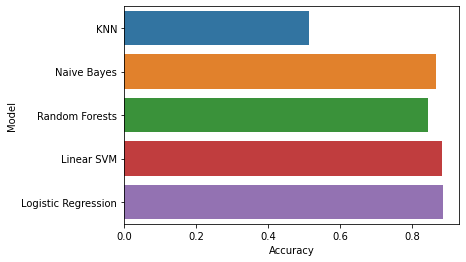

In [ ]:
sns.barplot(data = df,x='Accuracy',y='Model')
plt.show()

**For TFIDF**

In [ ]:
Models = np.array(['KNN','Naive Bayes','Random Forests','Linear SVM','Logistic Regression'])
TF_scores = np.array([0.75508,0.87224,0.8482,0.89356,0.875])
df = pd.DataFrame()
df['Model'] = Models
df['Accuracy'] = TF_scores
df

,Model,Accuracy
0,KNN,0.75508
1,Naive Bayes,0.87224
2,Random Forests,0.84820
3,Linear SVM,0.89356
4,Logistic Regression,0.87500


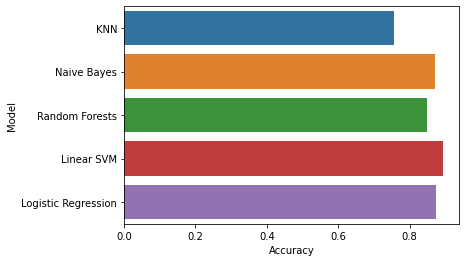

In [ ]:
sns.barplot(data = df, x='Accuracy', y='Model')
plt.show()

**For embedding**

In [ ]:
Models = np.array(['KNN','Naive Bayes','Random Forests','Linear SVM','Logistic Regression'])
TF_scores = np.array([0.51948,0.64,0.67272,0.769,0.773])
df = pd.DataFrame()
df['Model'] = Models
df['Accuracy'] = TF_scores
df


,Model,Accuracy
0,KNN,0.51948
1,Naive Bayes,0.64000
2,Random Forests,0.67272
3,Linear SVM,0.76900
4,Logistic Regression,0.77300


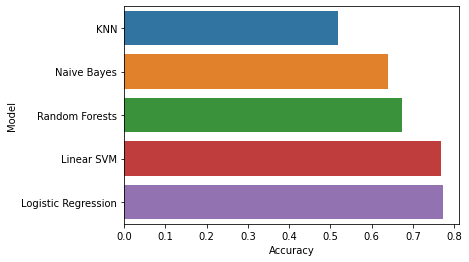

In [ ]:
sns.barplot(data = df,x='Accuracy',y='Model')
plt.show()

All compared

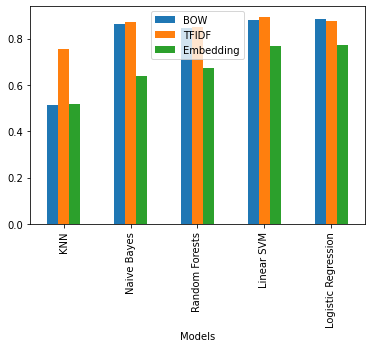

In [ ]:
dft = pd.DataFrame([['KNN', 0.51252, 0.75508, 0.51948],
                    ['Naive Bayes', 0.8644, 0.87224, 0.64], 
                   ['Random Forests', 0.8444, 0.8482, 0.67272],
                   ['Linear SVM', 0.882, 0.89356, 0.769],
                    ['Logistic Regression', 0.88448, 0.875, 0.773]],
                  columns=["Models", "BOW","TFIDF", "Embedding"])
 
dft.plot(x='Models',
        kind='bar',
        stacked=False)


Before preprocessing

**For bag of words**

In [ ]:
Models = np.array(['KNN','Naive Bayes','Random Forests','Linear SVM','Logistic Regression'])
TF_scores = np.array([0.51948,0.84852,0.84468,0.89508,0.88864])
df = pd.DataFrame()
df['Model'] = Models
df['Accuracy'] = TF_scores
df

,Model,Accuracy
0,KNN,0.51948
1,Naive Bayes,0.84852
2,Random Forests,0.84468
3,Linear SVM,0.89508
4,Logistic Regression,0.88864


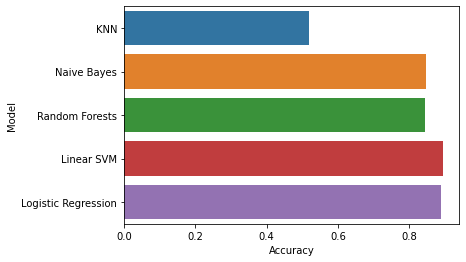

In [ ]:
sns.barplot(data = df,x='Accuracy',y='Model')
plt.show()

**For TFIDF**

In [ ]:
Models = np.array(['KNN','Naive Bayes','Random Forests','Linear SVM','Logistic Regression'])
TF_scores = np.array([0.79052,0.8352,0.83828,0.88104,0.88988])
df = pd.DataFrame()
df['Model'] = Models
df['Accuracy'] = TF_scores
df


,Model,Accuracy
0,KNN,0.79052
1,Naive Bayes,0.83520
2,Random Forests,0.83828
3,Linear SVM,0.88104
4,Logistic Regression,0.88988


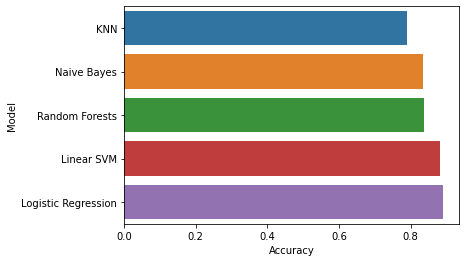

In [ ]:
sns.barplot(data = df,x='Accuracy',y='Model')
plt.show()